### Mixed model

The aquastat dataset has repeated measurements for each area over time, therefore linear mixed model with random intercepts is used to account for area-specific influence on their repeated observations.
$$Y_{ij}= \beta_{0}+b_{i}+\beta_{1}X_{1ij}+\beta_{2}X_{2ij}+\beta_{3}X_{3ij}+\beta_{4}X_{4ij}+\epsilon_{ij}$$

where\\
$Y_{ij}$ is Water Stress for year j in area i\\
$b_{i}$ is a area level effect on Water Stress which we assume $b_{i} \sim N(0,\tau^2)$\\
$X_{1ij}$ is the time of observation j in area i \\
$X_{2ij}$ is the value average temperature takes for observation j in area i\\
$X_{3ij}$ is the value GDP per capita takes for observation j in area i\\
$X_{4ij}$ is the value National Rainfall Index takes for observation j in area i\\
$\epsilon_{ij}$ is the deviation for observation j in area i which we assume $\epsilon_{ij} \sim N(0,\sigma^2)$


Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

Load and view aquastat data set

In [ ]:
df = pd.read_csv('https://mda-project-poland.s3.eu-west-3.amazonaws.com/ultimate+aquastat+(flat).csv')  # will be used for Time series analysis
df_GDP = pd.read_csv('https://mda-project-poland.s3.eu-west-3.amazonaws.com/GDP.csv')

In [ ]:
table = pd.pivot_table(data=df,values='Value',index=['Area','Year'],columns='Variable Name')
df=pd.DataFrame(table.to_records())
df.head(20)

,Area,Year,Agricultural water withdrawal as % of total renewable water resources,"Agriculture, value added (% GDP)",Average Temperature,Environmental Flow Requirements,GDP per capita,"Industry, value added to GDP",Long-term average annual precipitation in volume,MDG 7.5. Freshwater withdrawal as % of total renewable water resources,...,Prevalence of undernourishment (3-year average),SDG 6.4.1. Industrial Water Use Efficiency,SDG 6.4.1. Irrigated Agriculture Water Use Efficiency,SDG 6.4.1. Services Water Use Efficiency,SDG 6.4.1. Water Use Efficiency,SDG 6.4.2. Water Stress,"Services, value added to GDP",Total population with access to safe drinking-water (JMP),Total renewable water resources per capita,Total water withdrawal per capita
0,Afghanistan,1992.0,35.498101,54.207106,12.61,28.29,248.518890,5.530000e+08,213.48522,35.910480,...,29.5,25.311413,0.092143,10.237171,0.240400,63.337788,9.950000e+08,21.3,4510.012947,1619.567311
1,Afghanistan,1997.0,31.427856,62.416768,12.86,28.29,164.092893,4.220000e+08,213.48522,31.852952,...,45.6,9.091408,0.085820,7.763338,0.194590,56.181246,6.530000e+08,25.0,3374.984489,1075.032191
2,Afghanistan,2002.0,30.613807,45.134344,13.91,28.29,194.958382,9.150000e+08,213.48522,31.045461,...,47.8,11.426285,0.074770,15.252615,0.285607,54.757019,1.470000e+09,33.8,2890.609479,899.030431
3,Afghanistan,2007.0,30.613807,35.265942,13.80,28.29,389.985586,2.600000e+09,213.48522,31.045461,...,33.3,20.815284,0.110353,26.876683,0.549846,54.757019,4.030000e+09,42.6,2410.653428,751.752659
4,Afghanistan,2012.0,30.613807,28.556142,13.25,28.29,694.885618,4.360000e+09,213.48522,31.045461,...,24.7,23.227115,0.103801,47.639557,0.770774,54.757019,1.070000e+10,51.6,2096.505623,653.786919
5,Afghanistan,2017.0,30.613807,25.574670,13.12,28.29,605.557362,4.500000e+09,213.48522,31.045461,...,22.2,27.851985,0.118946,56.384791,0.911431,54.757019,1.090000e+10,55.3,1799.917253,561.297018
6,Afghanistan,2018.0,30.613807,22.440899,14.55,28.29,563.983834,4.800000e+09,213.48522,31.045461,...,23.0,31.220059,0.102132,57.683901,0.935917,54.757019,1.060000e+10,55.3,1757.509385,548.072294
7,Argentina,1992.0,NaN,5.193747,14.37,515.80,7366.759988,6.080000e+10,1643.00000,3.243937,...,NaN,NaN,NaN,NaN,NaN,7.886104,1.580000e+11,94.3,26133.540530,847.773175
8,Argentina,1997.0,2.455948,4.527197,15.14,515.80,8861.217104,6.800000e+10,1643.00000,3.343179,...,NaN,29.856348,0.080770,55.788386,12.184452,8.127364,1.940000e+11,95.6,24573.841260,822.584545
9,Argentina,2002.0,2.588954,8.848660,14.60,515.80,2918.591423,2.760000e+10,1643.00000,3.617493,...,3.0,22.932637,0.109619,39.086531,9.249703,8.794229,6.060000e+10,96.7,23253.697700,843.627906


In [ ]:
# drop undernourishment and add GDP  
df = df.drop('Prevalence of undernourishment (3-year average)', axis=1)  # TODO download correct data from AQUASTAT instead of dropping here
table_GDP = pd.pivot_table(data=df_GDP,values='Value',index=['Area','Year'],columns='Variable Name')
df_GDP=pd.DataFrame(table_GDP.to_records())
df_GDP

,Area,Year,Gross Domestic Product (GDP)
0,Afghanistan,1992.0,3.444711e+09
1,Afghanistan,1997.0,2.924589e+09
2,Afghanistan,2002.0,4.141524e+09
3,Afghanistan,2007.0,9.412162e+09
4,Afghanistan,2012.0,1.913650e+10
...,...,...,...
254,Zimbabwe,2002.0,8.215468e+09
255,Zimbabwe,2007.0,6.958295e+09
256,Zimbabwe,2012.0,1.711485e+10
257,Zimbabwe,2017.0,2.204090e+10


In [ ]:
df = df.merge(df_GDP, how='inner', on=['Area','Year'])

In [ ]:
df.rename(columns = {'SDG 6.4.2. Water Stress':'WaterStress'}, inplace = True)

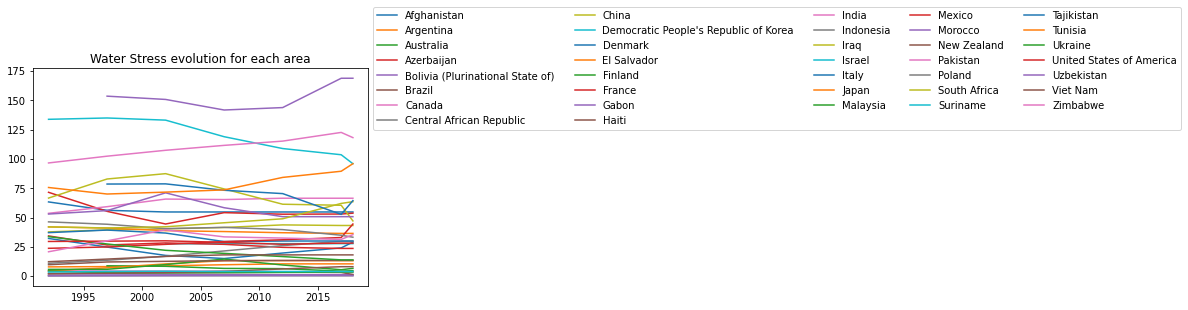

In [ ]:
start_idx = 0
while int(len(df)) != start_idx:
    plt.plot([1992, 1997, 2002, 2007, 2012, 2017,2018], df.loc[start_idx:(start_idx+6), ['WaterStress']])
    start_idx += 7
plt.title('Water Stress evolution for each area')
plt.legend(df['Area'].unique(),loc='center left', bbox_to_anchor=(1, 1),
          ncol=5, fancybox=True, shadow=False)
plt.show()

Area starts with high water stress tends to have high water stress in later observation. So there is high intra-area correlation between the observations. The trend of evolution for most of these ares are similar, therefore a mixed model with random intercept may be sufficient to take the intra-area correlation into account.

In [ ]:
df['Industry, value added (% GDP)']=df['Industry, value added to GDP']/df['Gross Domestic Product (GDP)']*100
df['Services, value added (% GDP)']=df['Services, value added to GDP']/df['Gross Domestic Product (GDP)']*100

In [ ]:
df.isnull().sum()

Area                                                                       0
Year                                                                       0
Agricultural water withdrawal as % of total renewable water resources      7
Agriculture, value added (% GDP)                                           0
Average Temperature                                                        4
Environmental Flow Requirements                                            0
GDP per capita                                                             0
Industry, value added to GDP                                               0
Long-term average annual precipitation in volume                           0
MDG 7.5. Freshwater withdrawal as % of total renewable water resources     5
National Rainfall Index (NRI)                                              7
Population density                                                         0
SDG 6.4.1. Industrial Water Use Efficiency                                 8

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.columns = df.columns.str.replace('%', 'per')
df.columns = df.columns.str.replace(',', '')
df.columns = df.columns.str.replace('(', '')
df.columns = df.columns.str.replace(')', '')
df.columns = df.columns.str.replace('.', '')
df.columns = df.columns.str.replace(' ', '_')

C:\Users\Nyx\AppData\Local\Temp\ipykernel_13848\3120722374.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace('(', '')
C:\Users\Nyx\AppData\Local\Temp\ipykernel_13848\3120722374.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace(')', '')
C:\Users\Nyx\AppData\Local\Temp\ipykernel_13848\3120722374.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.columns = df.columns.str.replace('.', '')


In [ ]:
df['Year']=df['Year']-1992

Multicollinearity check

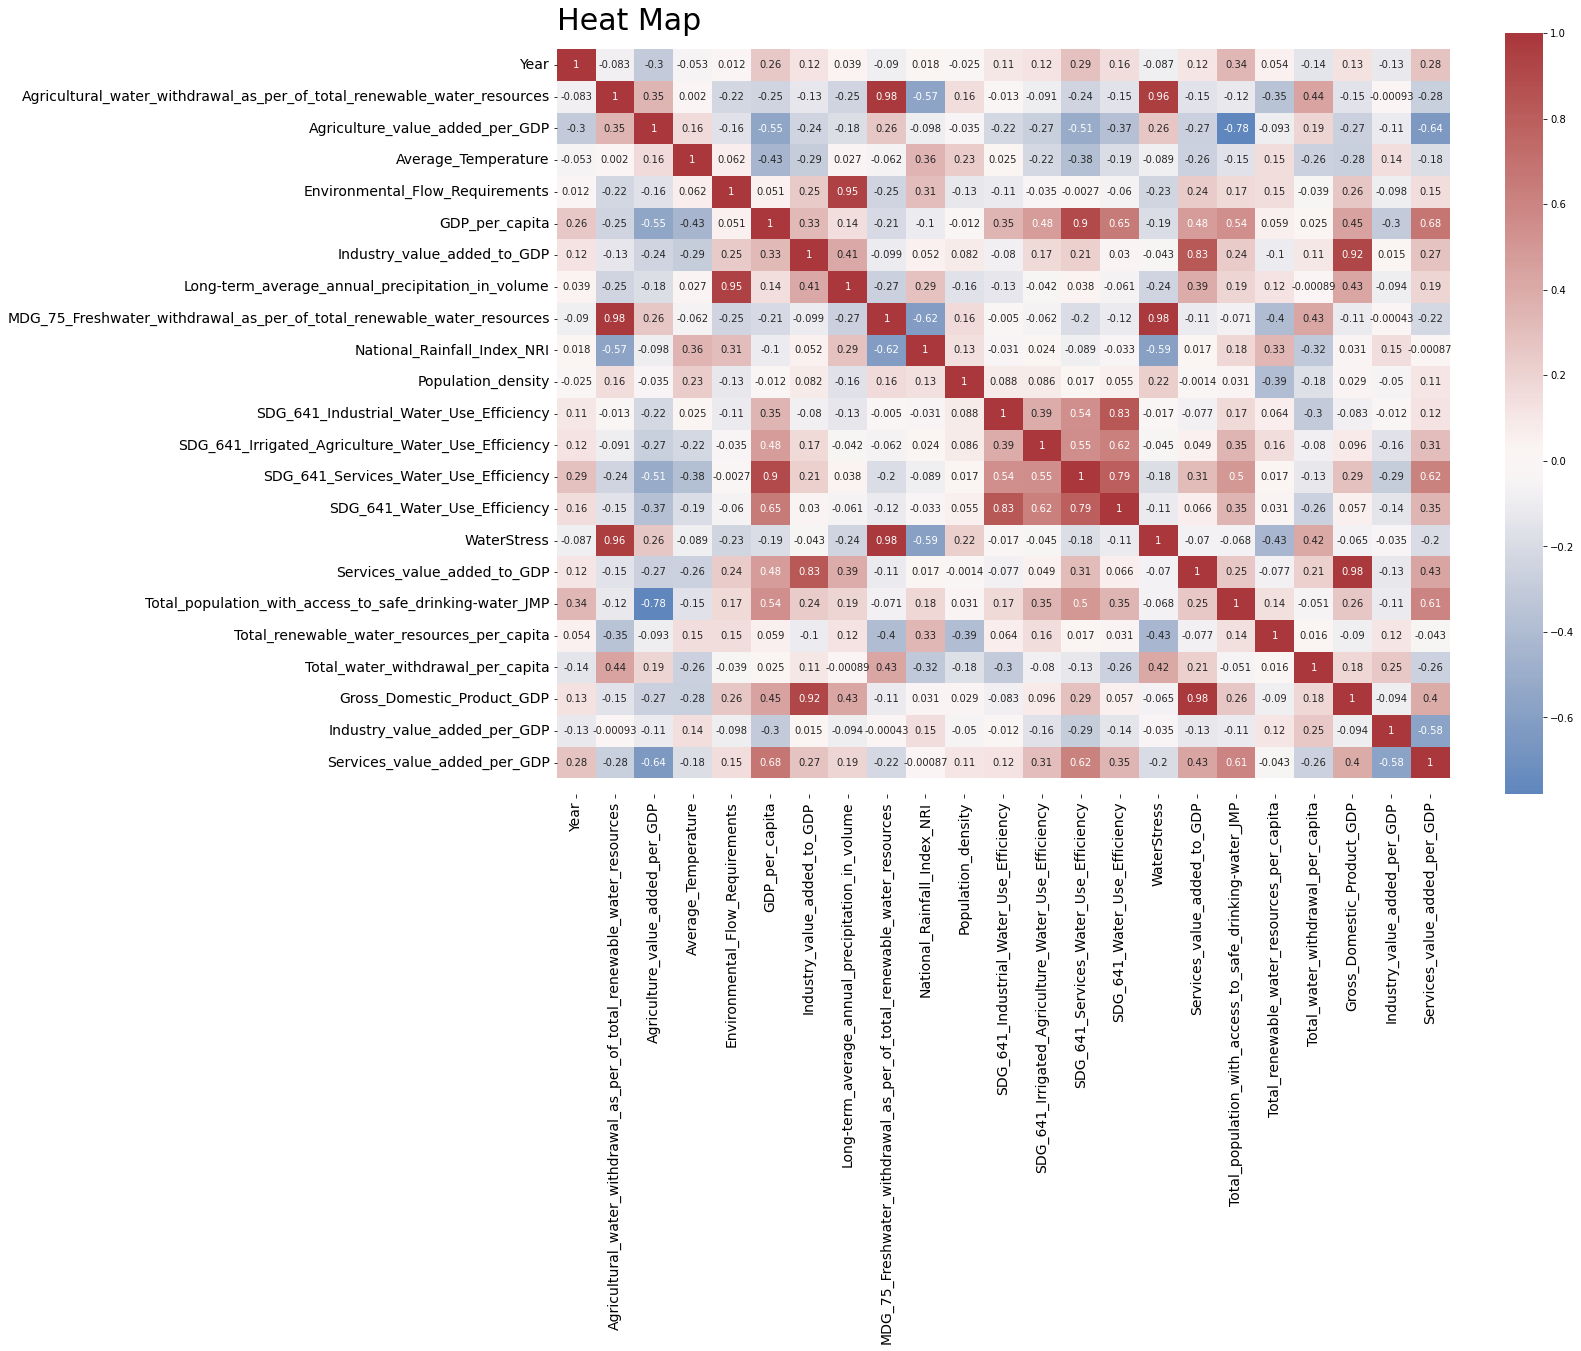

In [ ]:
plt.figure(figsize=(20,14))
ax = sns.heatmap(df.corr(), cmap='vlag', center=0, annot=True)
bottom, top = ax.get_ylim()
plt.text(0,-0.6, "Heat Map", fontsize = 30, color='Black', fontstyle='normal')
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.yticks(rotation=0, fontsize=14)
plt.xticks(rotation=90, fontsize=14)
plt.show()

 For covariates with high correlation, only one is included to avoid multicollinearity.

In [ ]:
md = smf.mixedlm("WaterStress ~ Year+Average_Temperature+GDP_per_capita+National_Rainfall_Index_NRI", df, groups=df["Area"])
mdf = md.fit()
print(mdf.summary())

                 Mixed Linear Model Regression Results
Model:                 MixedLM      Dependent Variable:      WaterStress
No. Observations:      208          Method:                  REML       
No. Groups:            36           Scale:                   37.5817    
Min. group size:       3            Log-Likelihood:          -771.1351  
Max. group size:       7            Converged:               Yes        
Mean group size:       5.8                                              
------------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025  0.975]
------------------------------------------------------------------------
Intercept                    78.898   11.823  6.673 0.000 55.726 102.070
Year                          0.107    0.066  1.626 0.104 -0.022   0.236
Average_Temperature          -1.180    0.659 -1.792 0.073 -2.471   0.111
GDP_per_capita               -0.000    0.000 -4.273 0.000 -0.001  -0.

the intraclass correlation coefficient (ICC) which measures the similarity of the responses within a random effect; in the current model with 1 cluster variable, this would be the similarity in water stress within the area. The ICC can range between 0 - 1 where 1 indicates perfect relationship within the clusters. To calculate the ICC one takes the variance of the clustering variable  and divides it by the unexplained variance of the model . The unexplained variance of the model can be found in the top right of the upper table labeled "scale".
From the result, the intra-area correlation is 983.383/(983.383+37.5817^2)=0.41. 

GDP_per_capita,National_Rainfall_Index_NRI are important factors in predicting water stress. Average Temperature is borderline significant. 

# Outlier detection

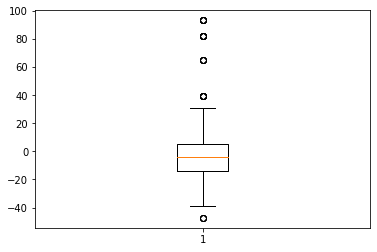

In [ ]:
area_specific_intercept=df['Area'].apply(lambda x: mdf.random_effects[x])
area_specific_intercept['Area']=df['Area']
area_specific_intercept
plt.boxplot(area_specific_intercept['Group'])
plt.show()

In [ ]:
df2=pd.DataFrame()
df2['intercept']=area_specific_intercept['Group'].unique()
df2['area']=df['Area'].unique()
df2

,intercept,area
0,-4.740113,Afghanistan
1,-31.501483,Argentina
2,-8.961002,Australia
3,-0.959620,Azerbaijan
4,-28.951410,Bolivia (Plurinational State of)
5,-12.390616,Brazil
6,-47.398790,Canada
7,-28.092328,Central African Republic
8,-11.035605,China
9,-8.110538,Denmark


In [ ]:
def find_boundaries(df, variable, distance):

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [ ]:
upper_boundary, lower_boundary = find_boundaries(df2, 'intercept', 1.5)
upper_boundary, lower_boundary

(28.122260164172307, -43.178613417533825)

In [ ]:
outliers = np.where(df2['intercept'] > upper_boundary, True,
            np.where(df2['intercept'] < lower_boundary, True, False))
outliers_df = df2.loc[outliers, 'area']
outliers_df
df2.loc[outliers,]

,intercept,area
6,-47.398790,Canada
15,39.389294,India
18,82.211762,Israel
25,65.088683,Pakistan
30,30.575026,Tunisia
33,93.138033,Uzbekistan


These countries have area-specific intercepts which deviates much from the mean evolution. 

## Conclusion

From the mixed model, we find that GDP_per_capita,National_Rainfall_Index_NRI are important factors in predicting water stress. The average temparature is borderline significant, this may due to the fact that we have limited number of observations. 

From the classifiication results, we find that Temperature, precipitation, population, GDP, water use efficiency and agricultural water withdrawal have an effect on water stress. 

In addition, according to the literature (Qian et al., 2021; Sun et al., 2017; Tang et al., 2012; Wang et al., 2018), GDP, population and precipitation are important factors for water demand prediction.

From all this, we decide to use precipitation, temperature, GDP, and population density for our prediction in the next step. But first, we should enrich the AQUASTAT data, as there are not enough observations.



## Reference


Qian, L., Wang, Z., Hong, M., Wang, H., & Wang, Y. (2021). A water shortage risk predicting model through estimating mutual information values between risk and risk factors. Environmental Earth Sciences, 80(23), 785. https://doi.org/10.1007/s12665-021-10094-x

Sun, Y., Liu, N., Shang, J., & Zhang, J. (2017). Sustainable utilization of water resources in China: A system dynamics model. Journal of Cleaner Production, 142, 613–625. https://doi.org/10.1016/j.jclepro.2016.07.110

Statsmodels.Regression.Mixed_linear_model.MixedLM — Statsmodels. https://www.statsmodels.org/dev/generated/statsmodels.regression.mixed_linear_model.MixedLM.html.

Shuang, Q., & Zhao, R. T. (2021). Water Demand Prediction Using Machine Learning Methods: A Case Study of the Beijing–Tianjin–Hebei Region in China. Water, 13(3), 310. https://doi.org/10.3390/w13030310

Tang, Z. Q., Liu, G., Xu, W. N., Xia, Z. Y., & Xiao, H. (2012). Water Demand Forecasting in Hubei Province with BP Neural Network Model. Advanced Materials Research, 599, 701–704. https://doi.org/10.4028/www.scientific.net/AMR.599.701

Wang, H., Wang, W., Cui, Z., Zhou, X., Zhao, J., & Li, Y. (2018). A new dynamic firefly algorithm for demand estimation of water resources. Information Sciences, 438, 95–106. https://doi.org/10.1016/j.ins.2018.01.041
